## IQL

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
from IPython.display import clear_output
from pettingzoo import ParallelEnv
from gymnasium import spaces
# FIX: Import np_random utility for correct seeding/random number generation
from gymnasium.utils.seeding import np_random 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Multi-Agent Independent Q-Learning (IQL) for the Extended Taxi Problem

#### This notebook implements Independent Q-Learning (IQL), the first Multi-Agent Reinforcement Learning (MARL) baseline for the competitive, two-taxi environment, based on the *PettingZoo* API.
##### *Goal:* Two agents (⁠ taxi_0 ⁠, ⁠ taxi_1 ⁠) compete to pick up a single passenger and drop them off at the destination first.

### 1. Setup and Environment Definition

In [37]:
# --- UTILITY FUNCTIONS ---

def get_mean_rewards(rewards_list, window=1000):
    """Calculates the rolling average of rewards for plotting."""
    if not rewards_list:
        return np.array([])
    return np.convolve(rewards_list, np.ones(window)/window, mode='valid')

STEP_PENALTY = -0.5
PICKUP_COOP = 25
PICKUP_WIN = 25
PICKUP_LOSE = -5
DROPOFF_COOP = 50
DROPOFF_WIN = 50
DROPOFF_LOSE = -10
INVALID_PICKUP = -5
WRONG_DROPOFF = -5

### 2. Custom Multi-Agent Taxi Environment (⁠ MultiTaxiEnv ⁠)
##### This class extends the PettingZoo ⁠ ParallelEnv ⁠ to handle the competitive 2-taxi dynamics.

In [38]:
class MultiTaxiEnv(ParallelEnv):
    metadata = {"render_modes": ["ansi", "human"], "name": "multi_taxi"}

    def __init__(self, render_mode="ansi", cooperative=True, num_taxis=2, rows=5, cols=5):
        # RNG
        self.np_random, _ = np_random()

        # Basic config
        self.cooperative = cooperative
        self.render_mode = render_mode
        self.rows = rows
        self.cols = cols

        # Fixed 5x5 Taxi-v3 style layout
        self.desc = np.asarray([
            "+---------+",
            "|R: | : :G|",
            "| : | : : |",
            "| : : : : |",
            "| | : | : |",
            "|Y| : |B: |",
            "+---------+",
        ], dtype="c")

        # Destination coordinates (R, G, Y, B)
        self.locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        # Agents / taxis
        self.num_taxis = num_taxis
        self.possible_agents = [f"taxi_{i}" for i in range(self.num_taxis)]
        self.agents = self.possible_agents[:]

        # Action space (same for all agents): 0..5
        self.action_spaces = {agent: spaces.Discrete(6) for agent in self.agents}

        # --- Observation space ---

        # For the 5x5 grid with *2 taxis*, we use the classic Taxi-v3-style encoding:
        # (my_row, my_col, opp_row, opp_col, pass_state, dest)
        # → 5 * 5 * 5 * 5 * 6 * 4 = 15000
        self.state_size = (self.rows * self.cols) ** self.num_taxis \
                  * (4 + self.num_taxis) \
                  * 4

        self.observation_spaces = {
            agent: spaces.Discrete(self.state_size) for agent in self.agents
        }

    def action_space(self, agent):
        return self.action_spaces[agent]

    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = np_random(seed)

        self.agents = self.possible_agents[:]
        self.timestep = 0

        # 1. Randomize Taxi Locations for all agents
        self.taxi_locs = {
            a: [self.np_random.integers(5), self.np_random.integers(5)]
            for a in self.agents
        }

        # 2. Random Passenger and Destination
        self.pass_idx = self.np_random.integers(4)      # 0-3 (R, G, Y, B)
        self.pass_loc = list(self.locs[self.pass_idx])  # actual coordinates

        self.dest_idx = self.np_random.integers(4)
        while self.dest_idx == self.pass_idx:
            self.dest_idx = self.np_random.integers(4)

        # 3. Passenger status:
        #    0 = waiting at self.pass_idx
        #    1..N = in taxi_0..taxi_{N-1}
        #    (we use pass_idx again when delivered, but episode usually ends)
        self.pass_status = 0

        observations = {a: self._encode_obs(a) for a in self.agents}
        infos = {a: {} for a in self.agents}
        return observations, infos

    def step(self, actions):
        # Default step cost
        rewards = {a: STEP_PENALTY for a in self.agents}
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        infos = {a: {} for a in self.agents}

        # Process in random order (break ties)
        agents_order = self.agents[:]
        self.np_random.shuffle(agents_order)

        for agent in agents_order:
            action = actions.get(agent)
            if action is None:
                continue

            row, col = self.taxi_locs[agent]

            # --- MOVEMENT (0–3) ---
            if action < 4:
                new_row, new_col = row, col
                if action == 0:                         # south
                    new_row = min(row + 1, self.rows - 1)
                elif action == 1:                       # north
                    new_row = max(row - 1, 0)
                elif action == 2:                       # east
                    if self.desc[1 + row, 2 * col + 2] == b":":
                        new_col = min(col + 1, self.cols - 1)
                elif action == 3:                       # west
                    if self.desc[1 + row, 2 * col] == b":":
                        new_col = max(col - 1, 0)

                self.taxi_locs[agent] = [new_row, new_col]

            # --- PICKUP (4) ---
            elif action == 4:
                agent_index = self.agents.index(agent)
                at_passenger = (self.taxi_locs[agent] == self.pass_loc)

                if self.pass_status == 0 and at_passenger:
                    # Successful pickup → passenger now in taxi agent_index
                    self.pass_status = agent_index + 1

                    if self.cooperative:
                        # Shared reward (all agents)
                        for a in self.agents:
                            rewards[a] += PICKUP_COOP
                    else:
                        # Competitive: winner gets +, others get small -
                        rewards[agent] += PICKUP_WIN
                        for a in self.agents:
                            if a != agent:
                                rewards[a] += PICKUP_LOSE

                elif self.pass_status == 0:
                    # Passenger waiting, but taxi is not at passenger location
                    rewards[agent] += INVALID_PICKUP

                else:
                    # Passenger already picked up
                    if self.cooperative:
                        rewards[agent] += INVALID_PICKUP
                    else:
                        # No extra penalty in competitive mode
                        pass

            # --- DROPOFF (5) ---
            elif action == 5:
                agent_index = self.agents.index(agent)
                carrying = (
                    self.pass_status == (agent_index + 1)
                )  # this taxi currently has the passenger

                if carrying:
                    dest_loc = list(self.locs[self.dest_idx])

                    if self.taxi_locs[agent] == dest_loc:
                        # Successful dropoff
                        if self.cooperative:
                            for a in self.agents:
                                rewards[a] += DROPOFF_COOP
                        else:
                            # Winner gets big reward, others a small negative
                            rewards[agent] += DROPOFF_WIN
                            for a in self.agents:
                                if a != agent:
                                    rewards[a] += WRONG_DROPOFF

                        self.pass_status = 3
                        terminations = {a: True for a in self.agents}

                    else:
                        # Wrong destination
                        rewards[agent] += WRONG_DROPOFF
                else:
                    # Not carrying passenger
                    rewards[agent] += WRONG_DROPOFF

        # New observations
        observations = {a: self._encode_obs(a) for a in self.agents}

        # Timeout truncation
        self.timestep += 1
        if self.timestep >= MAX_STEPS_PER_EPISODE:
            truncations = {a: True for a in self.agents}

        return observations, rewards, terminations, truncations, infos

    def _encode_obs(self, agent_id):
        # Encode all taxi positions in canonical order always: taxi_0, taxi_1, taxi_2...
        i = 0
    
        # 1. Encode taxi positions
        for taxi in self.possible_agents:
            r, c = self.taxi_locs[taxi]
            i = i * (self.rows * self.cols) + (r * self.cols + c)
    
        # 2. Encode passenger state
        # waiting → 0..3
        # carried by taxi_k → 4+k
        if self.pass_status == 0:                      # waiting
            pass_state = self.pass_idx                 # 0..3
        else:
            pass_state = 4 + (self.pass_status - 1)    # 4..(4+N-1)
    
        i = i * (4 + self.num_taxis) + pass_state
    
        # 3. Encode destination (0..3)
        i = i * 4 + self.dest_idx
    
        return i


    def render(self):
        # NOTE: This render is only fully correct for num_taxis == 2.
        # For >2 taxis, it's best to ignore rendering or extend it yourself.
        if self.render_mode != "ansi":
            return "Render mode not supported outside notebook."

        out = self.desc.copy().tolist()
        out = [[c.decode("utf-8") for c in line] for line in out]

        def set_char(r, c, ch):
            out[1 + r][2 * c + 1] = ch

        # Destination
        di, dj = self.locs[self.dest_idx]
        set_char(di, dj, out[1 + di][2 * dj + 1].upper())

        # Passenger
        if self.pass_status == 0:
            pi, pj = self.pass_loc
            set_char(pi, pj, out[1 + pi][2 * pj + 1].lower())

        # Only show first two taxis nicely
        if "taxi_0" in self.taxi_locs:
            t0_r, t0_c = self.taxi_locs["taxi_0"]
        else:
            t0_r, t0_c = 0, 0

        if "taxi_1" in self.taxi_locs:
            t1_r, t1_c = self.taxi_locs["taxi_1"]
        else:
            t1_r, t1_c = 0, 0

        if self.pass_status == 1:      # in taxi_0
            set_char(t0_r, t0_c, "T")
            set_char(t1_r, t1_c, "1")
        elif self.pass_status == 2:    # in taxi_1
            set_char(t0_r, t0_c, "0")
            set_char(t1_r, t1_c, "T")
        else:
            set_char(t0_r, t0_c, "0")
            set_char(t1_r, t1_c, "1")

        return "\n".join("".join(row) for row in out)


### 3. IQL Training Setup and Loop

In [39]:
# --- MARL Hyperparameters ---
LEARNING_RATE = 0.1     
DISCOUNT_FACTOR = 0.99
MAX_STEPS_PER_EPISODE = 150 

# Epsilon-Greedy Strategy Parameters 
EPSILON_START = 1.0     
EPSILON_END = 0.05      
EPSILON_DECAY_RATE = 0.00002 

def run_iql_training(cooperative=True, num_taxis=2):

    # Create environment
    env_marl = MultiTaxiEnv(render_mode="ansi", cooperative=cooperative, num_taxis=num_taxis)
    agents = env_marl.possible_agents
    EPISODES = 50000
    
    if num_taxis == 2:
        EPISODES = 50000
    elif num_taxis == 3:
        EPISODES = 150000
    else:
        EPISODES = 200000
    
    # Q-table sizes
    state_size = env_marl.observation_spaces[agents[0]].n
    action_size = env_marl.action_spaces[agents[0]].n
    
    # Create one Q-table per agent
    q_table = {a: np.zeros((state_size, action_size)) for a in agents}

    print(f"IQL State Size: {state_size} | Action Size: {action_size}")
    print(f"Agents: {agents}")
    print(f"Running in Cooperative Mode: {cooperative}")

    # ε-greedy
    epsilon = EPSILON_START
    
    # Store rewards for plotting
    training_rewards = {a: [] for a in agents}
    epsilon_values = []

    mode = "Cooperative" if cooperative else "Competitive"
    print(f"\n=== Starting IQL Training ({mode}) ===")

    # -------------------------
    #       TRAINING LOOP
    # -------------------------
    for episode in range(1, EPISODES + 1):
        
        observations, _ = env_marl.reset()
        terminated = {a: False for a in agents}
        truncated  = {a: False for a in agents}

        episode_rewards = {a: 0 for a in agents}

        for step in range(MAX_STEPS_PER_EPISODE):

            # choose action for each agent
            actions = {
                a: (env_marl.action_spaces[a].sample()
                    if np.random.random() < epsilon
                    else np.argmax(q_table[a][observations[a]]))
                for a in agents
            }

            # env step
            new_obs, rewards, terminated, truncated, _ = env_marl.step(actions)

            # Q-learning update per agent
            for a in agents:
                s  = observations[a]
                a0 = actions[a]
                r  = rewards[a]
                s2 = new_obs[a]

                old_q = q_table[a][s, a0]
                max_future_q = np.max(q_table[a][s2])

                q_table[a][s, a0] = (1 - LEARNING_RATE) * old_q + \
                                    LEARNING_RATE * (r + DISCOUNT_FACTOR * max_future_q)

                episode_rewards[a] += r

            observations = new_obs

            if any(terminated.values()) or any(truncated.values()):
                break

        # decay ε
        epsilon = max(EPSILON_END, epsilon - EPSILON_DECAY_RATE)
        epsilon_values.append(epsilon)

        # store rewards
        for a in agents:
            training_rewards[a].append(episode_rewards[a])

        # periodic logging
        if episode % 10000 == 0:
            print(f"Episode {episode} | Epsilon {epsilon:.3f} | ", end = ' ')
            for a in agents:
                avg_r = np.mean(training_rewards[a][-5000:])
                print(f" {a}: Avg Reward {avg_r:.2f} | ", end = ' ')
            print()

    print("\n=== IQL Training Completed ===")

    # return EVERYTHING needed for plotting + eval
    return {
        "env": env_marl,
        "q_table": q_table,
        "agents": agents,
        "training_rewards": training_rewards,   # dictionary of lists (per agent)
        "epsilon_values": epsilon_values
    }

### 4. Performance Test and Evaluation
##### We evaluate the learned policy using pure exploitation (no random actions).

In [40]:
"""Test policy performance after training"""

def run_iql_eval(results):
    
    eval_episodes = 10
    env_marl = results["env"]
    q_table  = results["q_table"]
    agents   = results["agents"]
    mode     = "Cooperative" if env_marl.cooperative else "Competitive"

    total_steps = 0
    steps_list = []
    total_wins = {a: 0 for a in agents}
    invalid_pickups = {a: 0 for a in agents}
    eval_rewards = {a: [] for a in agents}
    competitive_wins = {a: 0 for a in agents}

    print(f"\n--- Starting Evaluation ({mode}) for N={len(agents)} ---")

    for ep in range(eval_episodes):
        obs, _ = env_marl.reset()
        terminated = {a: False for a in agents}
        truncated  = {a: False for a in agents}
        ep_reward = {a: 0 for a in agents}
        steps = 0

        while not any(terminated.values()) and not any(truncated.values()):
            steps += 1

            # Exploitation only
            actions = {
                a: np.argmax(q_table[a][obs[a]])
                for a in agents
            }

            prev_status = env_marl.pass_status

            new_obs, rewards, terminated, truncated, _ = env_marl.step(actions)

            # accumulate reward
            for a in agents:
                ep_reward[a] += rewards[a]

            obs = new_obs

            if any(terminated.values()):
                steps_list.append(steps)
                total_steps += steps

                # log rewards
                for a in agents:
                    eval_rewards[a].append(ep_reward[a])

                if not env_marl.cooperative:
                    # competitive → only the carrier gets dropoff reward
                    for a in agents:
                        if rewards[a] > 0:
                            competitive_wins[a] += 1

                else:
                    # cooperative → all must succeed
                    if all(rewards[a] > 0 for a in agents):
                        for a in agents:
                            total_wins[a] += 1

                break

    if env_marl.cooperative:
        # All agents succeed together
        success_rate = (total_wins[agents[0]] / eval_episodes) * 100
    else:
        # Winner = taxi who delivered
        success_rate = (sum(competitive_wins.values()) / eval_episodes) * 100

    print(f"\n--- FINAL EVALUATION RESULTS ({mode}) ---")
    print(f"Total Episodes Tested: {eval_episodes}")
    print(f"Mean Steps per Episode: {total_steps / eval_episodes:.2f}")

    return {
        "steps": steps_list,
        "success_rate": success_rate,
        "eval_rewards": eval_rewards,
        "invalid_pickups": invalid_pickups,
        "wins": competitive_wins
    }

### 5. Calling Training and Evaluation

In [41]:
results_by_n = {}

for N in [2,3]:
    results_by_n[N] = {}
    print(f"Training and eval for N = {N}")

    # train
    coop_train = run_iql_training(cooperative=True, num_taxis=N)
    comp_train = run_iql_training(cooperative=False, num_taxis=N)

    # eval
    coop_eval = run_iql_eval(coop_train)
    comp_eval = run_iql_eval(comp_train)

    # store
    results_by_n[N]["coop"] = {
        "train": coop_train,
        "eval": coop_eval
    }
    results_by_n[N]["comp"] = {
        "train": comp_train,
        "eval": comp_eval
    }

Training and eval for N = 2
IQL State Size: 15000 | Action Size: 6
Agents: ['taxi_0', 'taxi_1']
Running in Cooperative Mode: True

=== Starting IQL Training (Cooperative) ===
Episode 10000 | Epsilon 0.800 |   taxi_0: Avg Reward -140.26 |   taxi_1: Avg Reward -140.35 |  
Episode 20000 | Epsilon 0.600 |   taxi_0: Avg Reward 14.12 |   taxi_1: Avg Reward 14.15 |  
Episode 30000 | Epsilon 0.400 |   taxi_0: Avg Reward 46.57 |   taxi_1: Avg Reward 46.80 |  
Episode 40000 | Epsilon 0.200 |   taxi_0: Avg Reward 60.14 |   taxi_1: Avg Reward 60.21 |  
Episode 50000 | Epsilon 0.050 |   taxi_0: Avg Reward 66.95 |   taxi_1: Avg Reward 66.94 |  

=== IQL Training Completed ===
IQL State Size: 15000 | Action Size: 6
Agents: ['taxi_0', 'taxi_1']
Running in Cooperative Mode: False

=== Starting IQL Training (Competitive) ===
Episode 10000 | Epsilon 0.800 |   taxi_0: Avg Reward -128.53 |   taxi_1: Avg Reward -129.85 |  
Episode 20000 | Epsilon 0.600 |   taxi_0: Avg Reward -12.17 |   taxi_1: Avg Reward -1

### 6. Plotting Functions

In [47]:
# ============================================================
# Utility: Rolling mean
# ============================================================
def rolling_mean(values, window=500):
    if len(values) < window:
        return values
    return np.convolve(values, np.ones(window)/window, mode="valid")

# ============================================================
# 1. Convergence Plots (per N, coop & comp)
# ============================================================
def plot_convergence(results_by_n, rolling_window=500):

    plt.figure(figsize=(18, 4 * len(results_by_n)))
    plot_index = 1

    for N, modes in results_by_n.items():
        for mode_label, result in modes.items():

            train = result["train"]
            agents = train["agents"]
            training_rewards = train["training_rewards"]

            plt.subplot(len(results_by_n), 2, plot_index)

            for a in agents:
                rm = rolling_mean(training_rewards[a], rolling_window)
                plt.plot(rm, label=a)

            plt.title(f"Convergence (N={N}, Mode={mode_label})")
            plt.xlabel("Episode")
            plt.ylabel("Rolling Mean Reward")
            plt.legend()
            plt.grid(True)

            plot_index += 1

    plt.tight_layout()
    plt.show()

# ============================================================
# 2. Steps-to-completion Scaling Plot
# ============================================================
def plot_steps(results_by_n):

    plt.figure(figsize=(14, 6))

    for N, modes in results_by_n.items():
        coop = modes["coop"]["eval"]["steps"]
        comp = modes["comp"]["eval"]["steps"]

        plt.hist(coop, alpha=0.4, bins=20, label=f"Coop N={N}")
        plt.hist(comp, alpha=0.4, bins=20, label=f"Comp N={N}")

    plt.title("Steps to Completion Across N")
    plt.xlabel("Steps")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# ============================================================
# 3. Success Rate vs N
# ============================================================
def plot_success_rate(results_by_n):

    Ns = []
    coop_rates = []
    comp_rates = []

    for N, modes in results_by_n.items():
        Ns.append(N)
        coop_rates.append(modes["coop"]["eval"]["success_rate"])
        comp_rates.append(modes["comp"]["eval"]["success_rate"])

    x = np.arange(len(Ns))
    w = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - w/2, coop_rates, width=w, label="Cooperative", color="green")
    plt.bar(x + w/2, comp_rates, width=w, label="Competitive", color="red")

    plt.xticks(x, Ns)
    plt.ylabel("Success Rate (%)")
    plt.xlabel("Number of Agents")
    plt.ylim(0,100)
    plt.grid(axis="y")
    plt.title("Success Rate vs N")
    plt.legend()
    plt.show()

# ============================================================
# 4. Reward Distribution Across N (Coop & Comp)
# ============================================================
def plot_reward_distributions(results_by_n):

    plt.figure(figsize=(20, 4 * len(results_by_n)))
    plot_idx = 1

    for N, modes in results_by_n.items():

        for mode_label, res in modes.items():

            agents = res["train"]["agents"]
            eval_res = res["eval"]["eval_rewards"]

            plt.subplot(len(results_by_n), 2, plot_idx)

            data = [eval_res[a] for a in agents]
            plt.boxplot(data, labels=agents)

            plt.title(f"Eval Reward Distribution (N={N}, Mode={mode_label})")
            plt.grid(True)

            plot_idx += 1

    plt.tight_layout()
    plt.show()

# ============================================================
# 5. Competitive Winrate Heatmap (Optional)
# ============================================================
def plot_winrate_heatmap(results_by_n):
    import seaborn as sns

    plt.figure(figsize=(12, 2 * len(results_by_n)))
    idx = 1

    for N, modes in results_by_n.items():

        comp_eval = modes["comp"]["eval"]
        agents = modes["comp"]["train"]["agents"]
        win_counts = np.array([comp_eval["wins"][a] for a in agents])[None, :]

        plt.subplot(len(results_by_n), 1, idx)
        sns.heatmap(win_counts, annot=True, cmap="Reds",
                    xticklabels=agents,
                    yticklabels=[f"N={N}"],
                    cbar=False)
        plt.title(f"Competitive Win Heatmap (N={N})")

        idx += 1

    plt.tight_layout()
    plt.show()

# ============================================================
# MASTER WRAPPER — Call All Plots
# ============================================================
def plot_all(results_by_n):
    print("Plotting convergence...")
    plot_convergence(results_by_n)

    print("Plotting steps...")
    plot_steps(results_by_n)

    print("Plotting success rates...")
    plot_success_rate(results_by_n)

    print("Plotting reward distributions...")
    plot_reward_distributions(results_by_n)

    print("Plotting winrate heatmaps...")
    plot_winrate_heatmap(results_by_n)


Plotting convergence...


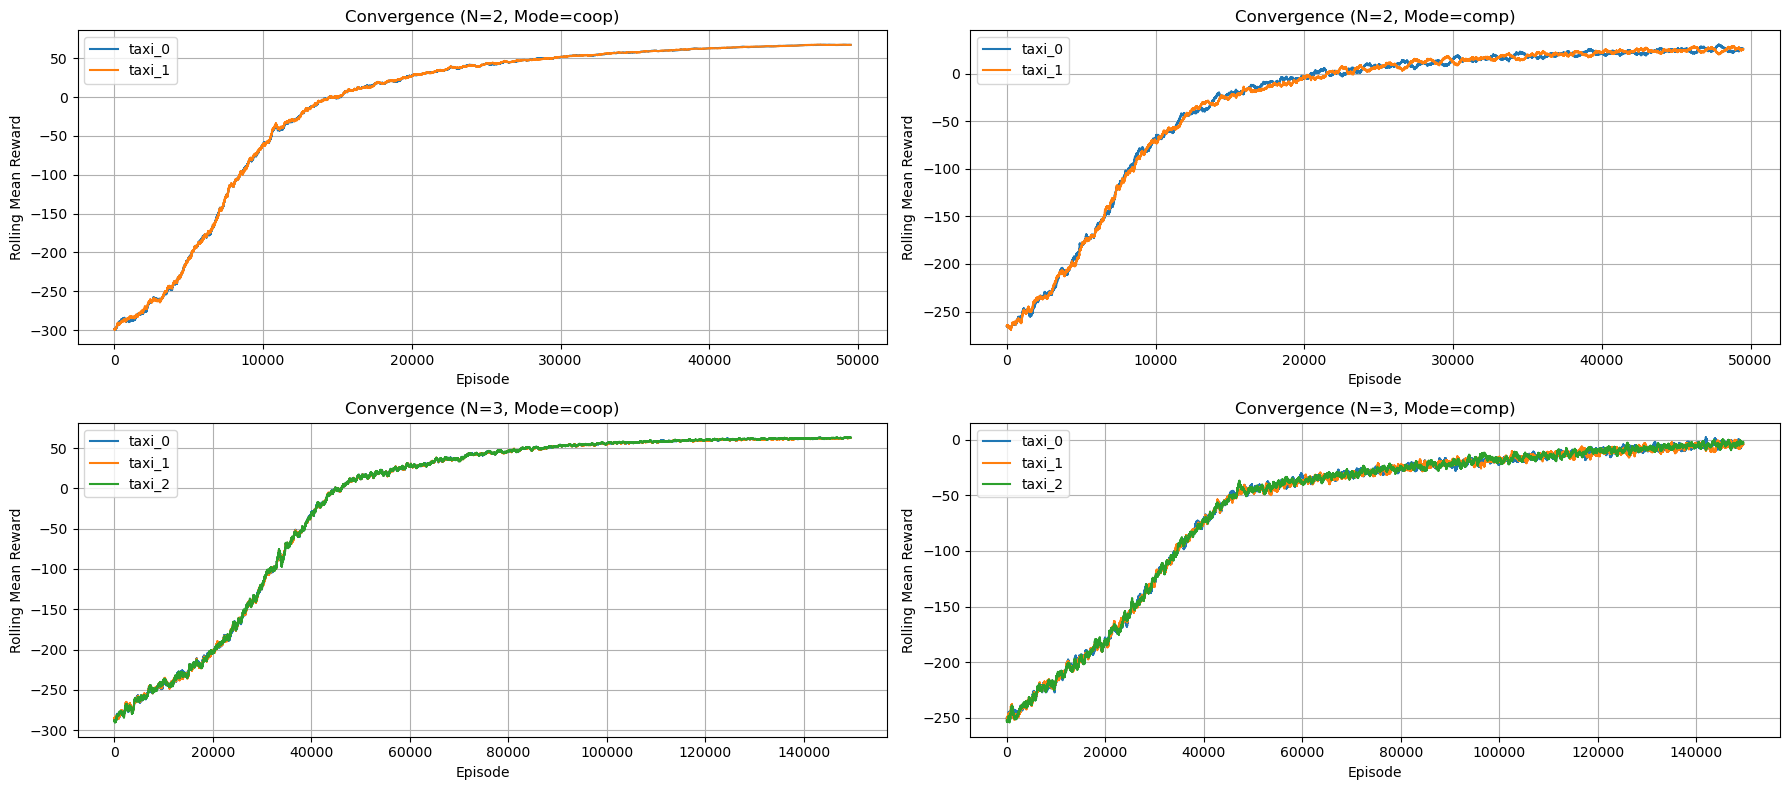

Plotting steps...


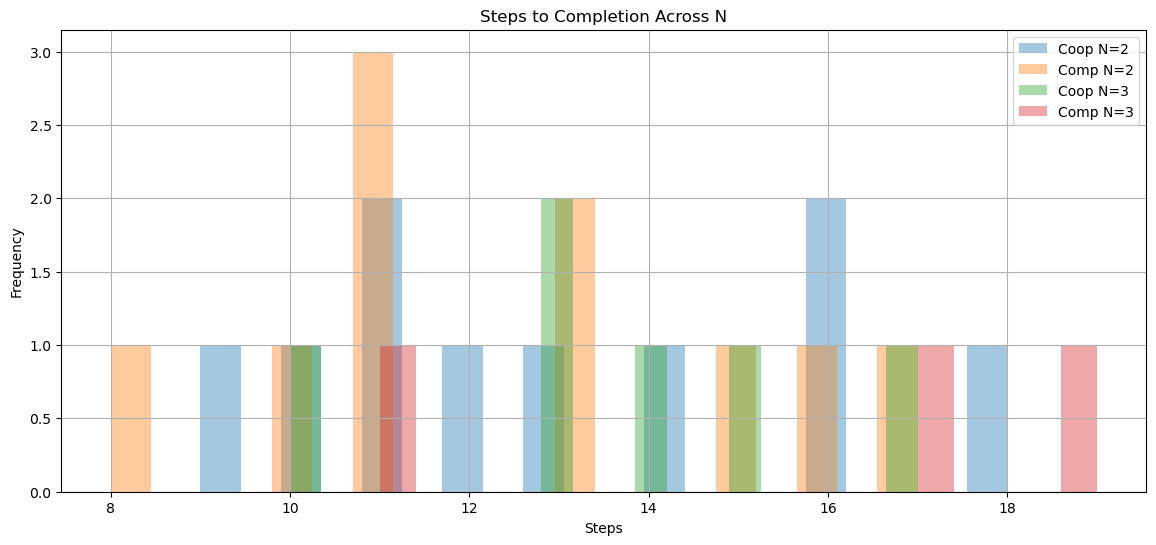

Plotting success rates...


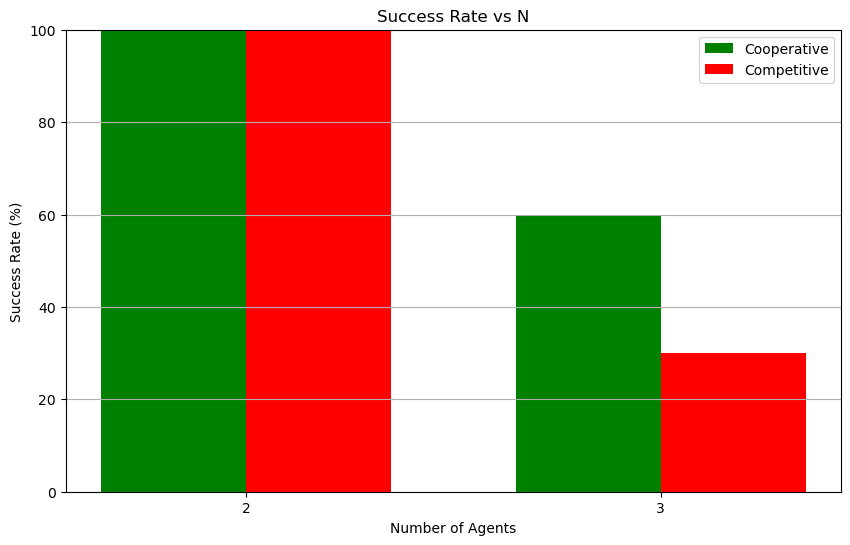

Plotting reward distributions...


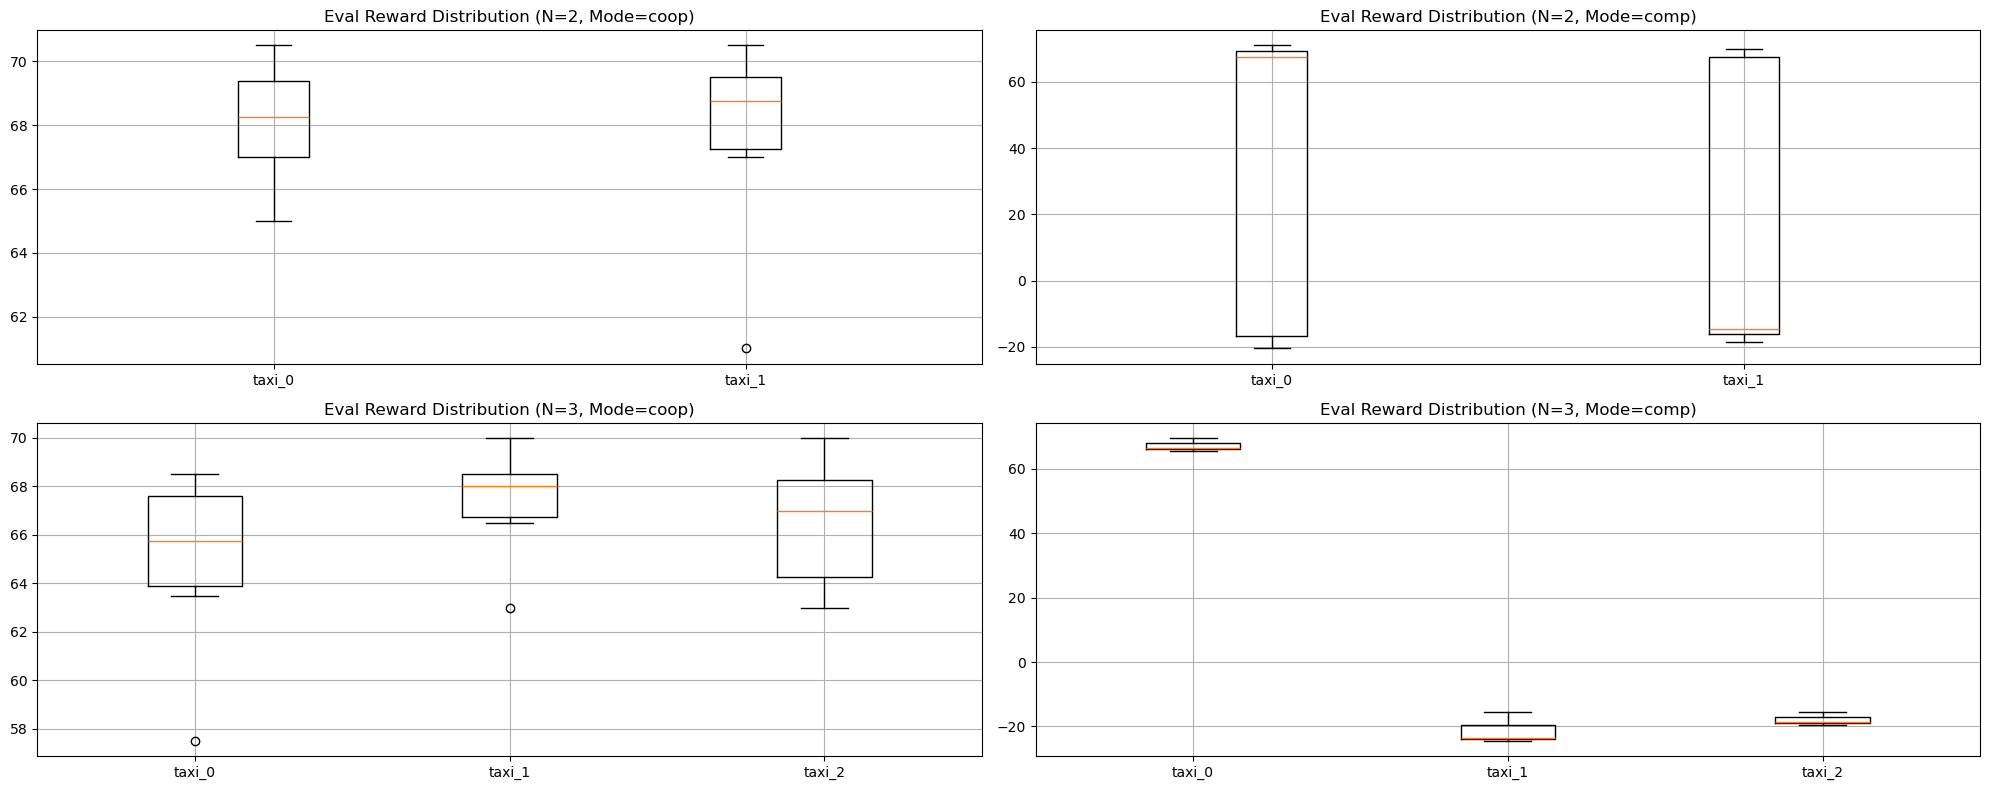

Plotting winrate heatmaps...


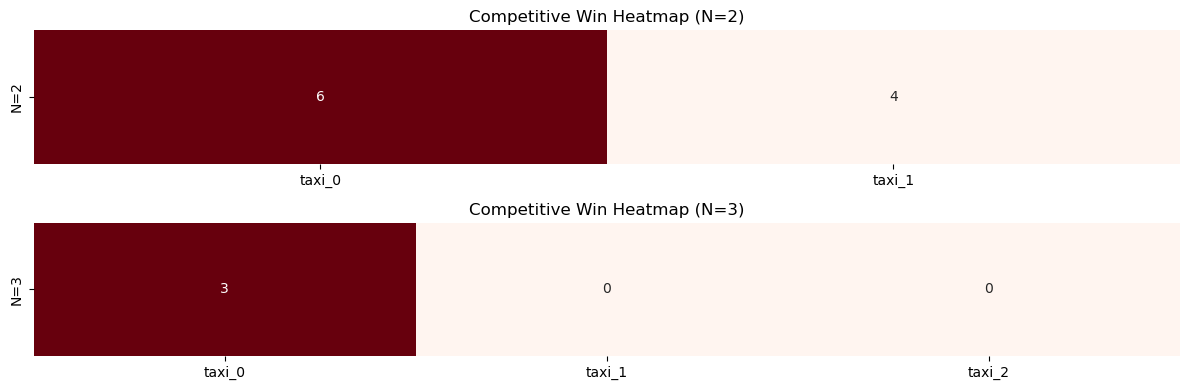

In [48]:
plot_all(results_by_n)

In [50]:
import os
import pickle
from datetime import datetime

def save_existing_qtables(train_result, N, run_label, base_dir="iql_q_tables"):
    """
    Saves Q-tables from an already trained result object.
    
    Parameters:
        train_result (dict): the dict returned by your training function
        N (int): number of taxis
        run_label (str): e.g., 'coop' or 'comp'
        base_dir (str): top-level folder where Q-tables will be saved
    """
    qtables = train_result["q_table"]   # dictionary: agent_name -> q-table

    # Make parent folder
    os.makedirs(base_dir, exist_ok=True)

    # Timestamp to avoid overwriting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder = f"N_{N}_{run_label}_{timestamp}"
    folder_path = os.path.join(base_dir, folder)
    os.makedirs(folder_path, exist_ok=True)

    # Save each agent's q-table
    for agent_name, q in qtables.items():
        file_path = os.path.join(folder_path, f"{agent_name}.pkl")
        with open(file_path, "wb") as f:
            pickle.dump(q, f)

    print(f" Saved Q-tables for N={N}, {run_label} at {folder_path}")

In [52]:
for N in [2, 3]:
    save_existing_qtables(results_by_n[N]["coop"]["train"], N, "coop")
    save_existing_qtables(results_by_n[N]["comp"]["train"], N, "comp")

 Saved Q-tables for N=2, coop at iql_q_tables/N_2_coop_20251130_172816
 Saved Q-tables for N=2, comp at iql_q_tables/N_2_comp_20251130_172816
 Saved Q-tables for N=3, coop at iql_q_tables/N_3_coop_20251130_172816
 Saved Q-tables for N=3, comp at iql_q_tables/N_3_comp_20251130_172816
